# Domains reputation

## Get data

In [1]:
import json
import pickle
import sys
import gaffer
import threatgraph
from tabulate import tabulate
import time
import hashlib
import pandas as pd
import math
import matplotlib.pyplot as plt
import whois_db
import numpy as np
import datetime

In [2]:
g = threatgraph.Gaffer()
g.use_cert()

### Matches

In [3]:
matches = pickle.load(open("cache.MATCH", "rb"))
blacklist = pickle.load(open("cache.BLACKLIST", "rb"))

In [4]:
############################################################################
# Collapsing blacklists.
############################################################################

# A func which maps a blacklist name to its shorter form throws away all after the dot.
def make_sbl(x):
    a = x.split(".")
    return a[0]

# Map all blacklists to shorter form.  This should return: apility, facebook, vt.
sbls=[make_sbl(v) for v in blacklist]
sbls=sorted(set(sbls))

# Return a column name to number map
sbls_ix={sbls[i]: i for i in range(0, len(sbls))}

In [5]:
sbls

['apility', 'facebook', 'vt']

In [6]:
sbls_ix

{'apility': 0, 'facebook': 1, 'vt': 2}

### Gaffer query for domains

In [7]:
############################################################################
# Fetch device -> IP -> DNS query -> domain edges
############################################################################

op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("dnsquery")
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("indomain", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()

url = "/rest/v2/graph/operations/execute/chunked"

res = g.execute_chunked(op)


### Convert to variety of data structures

In [8]:
############################################################################
# Process graph output, construct a variety of maps.
############################################################################

# Maps domain to timestamp buckets
timestamps = {}

# Maps domain to counts
counts = {}

# Maps (device,domain) -> True
doms = {}

# All domains
all_domains = set()

# All devices
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    domain = list(ent["entities"][3].keys())[0]
    k = (dev, domain)

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    if not domain in counts:
        counts[domain] = 0
        timestamps[domain] = set()

    counts[domain] += cnt
    timestamps[domain].update(ts)
    doms[k] = True
    
    all_domains.add(domain)
    all_devices.add(dev)

all_domains = list(all_domains)
all_devices = list(all_devices)

In [9]:
############################################################################
# Work out the earliest and latest timestamps.
############################################################################

smallest=None
largest=None
for v in timestamps:

    if smallest == None:
        smallest = min(timestamps[v])
    else:
        smallest = min(smallest, min(timestamps[v]))

    if largest == None:
        largest = max(timestamps[v])
    else:
        largest = max(largest, max(timestamps[v]))

print(smallest, largest)


1527238800.0 1532955600.0


## Construct reputation vector

In [10]:
############################################################################
# Construct domain vector:
#   device, domain, earliest timestamp, latest, largest gap, blacklists..., devices...
############################################################################

# This has true/false elements for whether a device has interacted with a domain or not.

# Takes a timestamp set and returns the largest distance between two adjacent
# elements.

def gap(s):
    last = min(s)
    gap = 0
    for v in sorted(s):
        gap = max(gap, v - last)
        last = v
    return gap

datas = []

for v in counts:

    domain = v
    tss = timestamps[v]
    cnt = counts[v]
    tss2 = tss.union(set([smallest, largest]))
    biggest_gap = gap(tss2)

    data = [domain, min(tss), max(tss), biggest_gap, cnt, 0, 0, 0]
    
    blacks = [0.0 for i in range(0, len(sbls))]
        
    if domain in matches:

        for v2 in matches[domain]:
            
            bl = v2["blacklist"]
            sbl = make_sbl(bl)
            thing_latest = v2["latest"]
            source = blacklist[bl]["source"]
            blocklist_latest = blacklist[bl]["latest"]
            prob = blacklist[bl]["probability"]

            blocklist_decay_period = 86400 * 360
            blocklist_age = time.time() - blocklist_latest
            blocklist_factor = blocklist_decay_period - blocklist_age
            blocklist_factor /= blocklist_decay_period
            if blocklist_factor < 0: blocklist_factor = 0

            thing_decay_period = 86400 * 28
            thing_age = time.time() - thing_latest
            thing_factor = thing_decay_period - thing_age
            thing_factor /= thing_decay_period
            if thing_factor < 0: thing_factor = 0
            
            prob = prob * thing_factor * blocklist_factor

            prob = 1.0 - ((1.0 - blacks[sbls_ix[sbl]]) * (1.0 - prob))
            blacks[sbls_ix[sbl]] = prob

    data = data + blacks
    
    for dev in all_devices:
        if (dev, domain) in doms:
            data.append(1)
        else:
            data.append(0)
    
    datas.append(data)

In [11]:
cols = ["domain", "first", "last", "gap", "count", "devices", "created", "updated"] + sbls + all_devices
df = pd.DataFrame(datas, columns=cols)

df = df.set_index(["domain"])

In [12]:
df["devices"] = df[all_devices].sum(axis=1)

In [13]:
# Now have domain, first and last observation and whether or not a device has used it.
df

,first,last,gap,count,devices,created,updated,apility,facebook,vt,...,essential-chrome,MalcomWare-PC,nervings-cb,languid-mac,calcannea-cb,raymond-mac,terrestrial-mac,boundless-mac,turing-chromebook,simon-macpro
domain,,,,,,,,,,,,,,,,,,,,,
verisign.com,1.529158e+09,1.532300e+09,1918800.0,89,10,0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
trustnetworks.com,1.528207e+09,1.532956e+09,968400.0,40082,32,0,0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
servebom.com,1.528708e+09,1.532952e+09,1468800.0,51,15,0,0,0.0,0.0,0.0,...,1,0,1,1,0,1,1,1,0,0
openx.net,1.528211e+09,1.532956e+09,972000.0,2507,23,0,0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,0,1
adadvisor.net,1.528211e+09,1.532765e+09,972000.0,117,19,0,0,0.0,0.0,0.0,...,0,1,1,1,0,1,1,1,0,1
krxd.net,1.528211e+09,1.532952e+09,972000.0,2305,27,0,0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
google.com,1.527239e+09,1.532956e+09,439200.0,363538,37,0,0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
microsoft.com,1.528207e+09,1.532956e+09,968400.0,24072,23,0,0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,0,1
freetype.org,1.528736e+09,1.528736e+09,4219200.0,4,2,0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Add whois data

In [14]:
whois = pickle.load(open("db.WHOIS", "rb"))

In [15]:
[(d, whois[d].created, whois[d].updated) for d in whois]

[('responsetap.com',
  datetime.datetime(2012, 10, 5, 8, 44, 22),
  datetime.datetime(2018, 4, 13, 14, 20, 52)),
 ('cbsinteractive.com',
  datetime.datetime(2006, 11, 7, 4, 6, 47),
  datetime.datetime(2017, 7, 20, 21, 6, 26)),
 ('oixnet.org',
  datetime.datetime(2013, 3, 3, 21, 45, 39),
  datetime.datetime(2018, 5, 22, 20, 25, 46)),
 ('ntent.com',
  datetime.datetime(1997, 4, 30, 4, 0),
  datetime.datetime(2018, 1, 31, 0, 56, 34)),
 ('pressdns.com',
  datetime.datetime(2010, 7, 8, 1, 45, 17),
  datetime.datetime(2018, 4, 14, 4, 15, 59)),
 ('ip-158-69-7.net',
  datetime.datetime(2015, 6, 15, 10, 52, 44),
  datetime.datetime(2018, 6, 15, 3, 49, 8)),
 ('guypadfield.com',
  datetime.datetime(1999, 2, 7, 5, 0),
  datetime.datetime(2014, 2, 9, 20, 51, 54)),
 ('mahalo.com',
  datetime.datetime(1995, 2, 21, 5, 0),
  datetime.datetime(2018, 2, 19, 12, 41, 11)),
 ('oembed.com',
  datetime.datetime(2008, 3, 21, 5, 19, 46),
  datetime.datetime(2018, 1, 26, 19, 59, 42)),
 ('dynapis.info',
  datetim

In [16]:
whois["trustnetworks.com"].created.strftime("%Y-%m-%d")

'2003-07-13'

In [17]:
whois["trustnetworks.com"].updated.strftime("%Y-%m-%d")

'2018-07-14'

In [18]:
created = lambda d: whois[d].created.timestamp() if d in whois and whois[d].created != None else None
updated = lambda d: whois[d].updated.timestamp() if d in whois and whois[d].updated != None else None

print(created("google.com"))
print(updated("google.com"))

874292400.0
1519238707.0


In [19]:
df["created"] = [created(v) for v in df.index]
df["updated"] = [updated(v) for v in df.index]

In [20]:
df

,first,last,gap,count,devices,created,updated,apility,facebook,vt,...,essential-chrome,MalcomWare-PC,nervings-cb,languid-mac,calcannea-cb,raymond-mac,terrestrial-mac,boundless-mac,turing-chromebook,simon-macpro
domain,,,,,,,,,,,,,,,,,,,,,
verisign.com,1.529158e+09,1.532300e+09,1918800.0,89,10,8.020620e+08,1.527480e+09,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
trustnetworks.com,1.528207e+09,1.532956e+09,968400.0,40082,32,1.058117e+09,1.531526e+09,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
servebom.com,1.528708e+09,1.532952e+09,1468800.0,51,15,1.325785e+09,1.513078e+09,0.0,0.0,0.0,...,1,0,1,1,0,1,1,1,0,0
openx.net,1.528211e+09,1.532956e+09,972000.0,2507,23,8.475156e+08,1.492723e+09,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,0,1
adadvisor.net,1.528211e+09,1.532765e+09,972000.0,117,19,1.207681e+09,1.518115e+09,0.0,0.0,0.0,...,0,1,1,1,0,1,1,1,0,1
krxd.net,1.528211e+09,1.532952e+09,972000.0,2305,27,1.274214e+09,1.529615e+09,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
google.com,1.527239e+09,1.532956e+09,439200.0,363538,37,8.742924e+08,1.519239e+09,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
microsoft.com,1.528207e+09,1.532956e+09,968400.0,24072,23,6.731532e+08,1.413367e+09,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,0,1
freetype.org,1.528736e+09,1.528736e+09,4219200.0,4,2,8.952876e+08,1.524501e+09,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Scoring device based on when the domain was first accessed

In [21]:
# Calculate the number of hours since domain first seen in use.
decay = 86400
df["age"] = (time.time() - df["first"]) / decay

In [22]:
# Make a score, which is e ** (- x)
# Lands in the range 0 to 1.

df["score"] = df["age"].apply(lambda x: math.e ** (0 - x) ).round(2)

In [23]:
df.sort_values("devices", ascending=False)

,first,last,gap,count,devices,created,updated,apility,facebook,vt,...,nervings-cb,languid-mac,calcannea-cb,raymond-mac,terrestrial-mac,boundless-mac,turing-chromebook,simon-macpro,age,score
domain,,,,,,,,,,,,,,,,,,,,,
gstatic.com,1.528204e+09,1.532956e+09,964800.0,63561,37,1.202717e+09,1.517350e+09,0.0,0.000000,0.0,...,1,1,1,1,1,1,1,1,55.032998,0.0
google.com,1.527239e+09,1.532956e+09,439200.0,363538,37,8.742924e+08,1.519239e+09,0.0,0.000000,0.0,...,1,1,1,1,1,1,1,1,66.199665,0.0
googleusercontent.com,1.528207e+09,1.532956e+09,968400.0,23156,36,1.226938e+09,1.517350e+09,0.0,0.000000,0.0,...,1,1,1,1,1,1,1,1,54.991331,0.0
doubleclick.net,1.528207e+09,1.532956e+09,968400.0,30060,36,8.217684e+08,1.513420e+09,0.0,0.000000,0.0,...,1,1,1,1,1,1,1,1,54.991331,0.0
google-analytics.com,1.528207e+09,1.532956e+09,968400.0,7834,36,1.121666e+09,1.529138e+09,0.0,0.000000,0.0,...,1,1,1,1,1,1,1,1,54.991331,0.0
googleapis.com,1.527678e+09,1.532956e+09,439200.0,71151,36,1.106676e+09,1.514111e+09,0.0,0.000000,0.0,...,1,1,1,1,1,1,1,1,61.116331,0.0
youtube.com,1.528207e+09,1.532956e+09,968400.0,2786,35,1.108444e+09,1.517350e+09,0.0,0.000000,0.0,...,1,1,1,1,1,1,1,1,54.991331,0.0
amazonaws.com,1.528207e+09,1.532956e+09,968400.0,26281,34,1.124327e+09,1.520545e+09,0.0,0.000000,0.0,...,1,1,1,1,1,1,1,1,54.991331,0.0
googletagmanager.com,1.528207e+09,1.532956e+09,968400.0,1741,34,1.321055e+09,1.507624e+09,0.0,0.000000,0.0,...,1,1,1,1,1,1,1,1,54.991331,0.0


In [24]:
df2 = df.copy()
for v in all_devices:
    df2[v] = df[v] * df["score"]

In [25]:
df2.sort_values("devices", ascending=False)

,first,last,gap,count,devices,created,updated,apility,facebook,vt,...,nervings-cb,languid-mac,calcannea-cb,raymond-mac,terrestrial-mac,boundless-mac,turing-chromebook,simon-macpro,age,score
domain,,,,,,,,,,,,,,,,,,,,,
gstatic.com,1.528204e+09,1.532956e+09,964800.0,63561,37,1.202717e+09,1.517350e+09,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.032998,0.0
google.com,1.527239e+09,1.532956e+09,439200.0,363538,37,8.742924e+08,1.519239e+09,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.199665,0.0
googleusercontent.com,1.528207e+09,1.532956e+09,968400.0,23156,36,1.226938e+09,1.517350e+09,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.991331,0.0
doubleclick.net,1.528207e+09,1.532956e+09,968400.0,30060,36,8.217684e+08,1.513420e+09,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.991331,0.0
google-analytics.com,1.528207e+09,1.532956e+09,968400.0,7834,36,1.121666e+09,1.529138e+09,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.991331,0.0
googleapis.com,1.527678e+09,1.532956e+09,439200.0,71151,36,1.106676e+09,1.514111e+09,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.116331,0.0
youtube.com,1.528207e+09,1.532956e+09,968400.0,2786,35,1.108444e+09,1.517350e+09,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.991331,0.0
amazonaws.com,1.528207e+09,1.532956e+09,968400.0,26281,34,1.124327e+09,1.520545e+09,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.991331,0.0
googletagmanager.com,1.528207e+09,1.532956e+09,968400.0,1741,34,1.321055e+09,1.507624e+09,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.991331,0.0


## Compute per-device score

In [26]:
score_cols = df2.columns[10:-2]
score1 = df2[score_cols].sum().to_frame("score")
score1 /= score1.max()

In [27]:
score1.sort_values(by="score", ascending=False)

,score
theatergoing-mac,1.000000
appropriate-android,0.625734
raymond-mac,0.488521
turing-minimacbook,0.426588
tirasse-mac,0.360384
essential-chrome,0.206086
dramatic-mac,0.170315
misskitty-mac,0.120662
languid-mac,0.107314
nervings-cb,0.047517


In [28]:
def func(data):
    p = 1.0
    for v in data:
        p = p * (1 - v)
    return 1 - p

score2 = df2[score_cols].apply(func).to_frame("score").round(2)

In [29]:
score2.sort_values("score", ascending=False)

,score
languid-mac,1.00
tirasse-mac,1.00
appropriate-android,1.00
essential-chrome,1.00
turing-minimacbook,1.00
theatergoing-mac,1.00
raymond-mac,1.00
misskitty-mac,0.99
dramatic-mac,0.98
nervings-cb,0.89


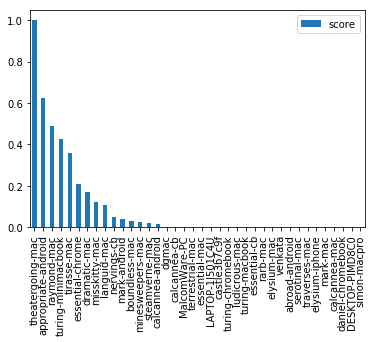

In [30]:
plt.figure(figsize=(20, 30))
score1.sort_values("score", ascending=False).plot.bar()
plt.show()

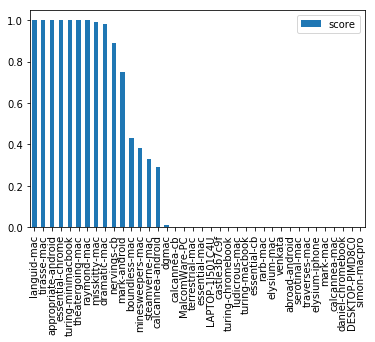

In [31]:
plt.figure(figsize=(20, 30))
score2.sort_values("score", ascending=False).plot.bar()
plt.show()

## Same thing but reduce score if more devices access that domain

In [32]:
# Calculate the number of hours since domain first seen in use.
df["age"] = (time.time() - df["first"]) / decay

In [33]:
# Make a score, which is e ** (- x)
# Lands in the range 0 to 1.
# Difference here is that score is reduced with higher device count.
df["score"] = df["age"].apply(lambda x: math.e ** (0 - x) ).round(2)
df["score"] /= 2 ** df["devices"]

In [34]:
df2 = df.copy()
for v in all_devices:
    df2[v] = df[v] * df["score"]

In [35]:
score1 = df2[score_cols].sum().to_frame("score")
score1 /= score1.max()

In [36]:
score1.sort_values(by="score", ascending=False)

,score
theatergoing-mac,1.000000
appropriate-android,0.540428
raymond-mac,0.466299
turing-minimacbook,0.420692
tirasse-mac,0.256222
essential-chrome,0.206242
dramatic-mac,0.169783
misskitty-mac,0.114019
languid-mac,0.108166
nervings-cb,0.047895


In [37]:
def func(data):
    p = 1.0
    for v in data:
        p = p * (1 - v)
    return 1 - p

score2 = df2[score_cols].apply(func).to_frame("score").round(2)

In [38]:
score2.sort_values("score", ascending=False)

,score
theatergoing-mac,1.00
raymond-mac,1.00
appropriate-android,1.00
turing-minimacbook,0.98
tirasse-mac,0.94
essential-chrome,0.92
dramatic-mac,0.83
languid-mac,0.74
misskitty-mac,0.73
nervings-cb,0.45


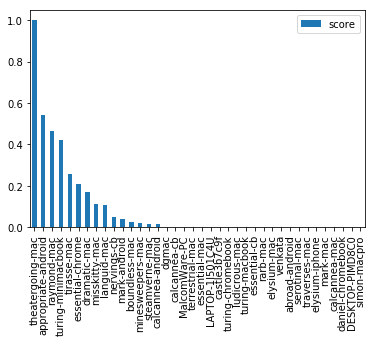

In [39]:
plt.figure(figsize=(20, 30))
score1.sort_values("score", ascending=False).plot.bar()
plt.show()

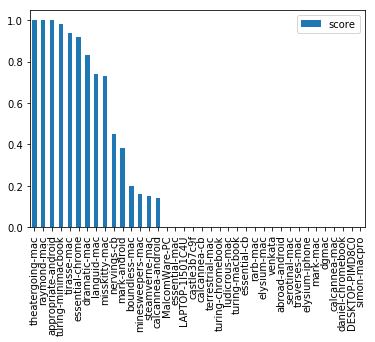

In [40]:
plt.figure(figsize=(20, 30))
score2.sort_values("score", ascending=False).plot.bar()
plt.show()

## Age based on WHOIS data

In [41]:
# Calculate the number of hours since domain first seen in use.
decay = 86400 * 3
df["discovered"] = df[["updated","first"]].apply(min, axis=1)
df["age"] = (time.time() - df["discovered"]) / decay

In [42]:
df.sort_values("discovered", ascending=False)

,first,last,gap,count,devices,created,updated,apility,facebook,vt,...,languid-mac,calcannea-cb,raymond-mac,terrestrial-mac,boundless-mac,turing-chromebook,simon-macpro,age,score,discovered
domain,,,,,,,,,,,,,,,,,,,,,
gchq.gov.uk,1.532696e+09,1.532696e+09,5457600.0,1,1,1.063753e+09,1.532905e+09,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,1.011007,0.02500,1.532696e+09
sims2artists.com,1.532729e+09,1.532729e+09,5490000.0,1,1,1.218648e+09,1.532689e+09,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,1.041003,0.03500,1.532689e+09
newsweektravel.com,1.532711e+09,1.532711e+09,5472000.0,1,1,1.500982e+09,1.532615e+09,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,1.323827,0.03000,1.532615e+09
crains.com,1.532599e+09,1.532599e+09,5360400.0,2,2,9.433010e+08,1.532725e+09,0.0,0.000000,0.0,...,0,0,0,0,1,0,0,1.386007,0.00500,1.532599e+09
svardbrogard.com,1.532570e+09,1.532570e+09,5331600.0,3,1,1.511507e+09,1.532844e+09,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,1.497118,0.00500,1.532570e+09
bc.edu,1.532862e+09,1.532862e+09,5623200.0,1,1,6.653664e+08,1.532560e+09,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,1.538785,0.16500,1.532560e+09
biznax.com,1.532722e+09,1.532722e+09,5482800.0,1,1,1.524636e+09,1.532498e+09,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,1.774896,0.03000,1.532498e+09
1plusx.com,1.532628e+09,1.532628e+09,5389200.0,1,1,1.414526e+09,1.532498e+09,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,1.776466,0.01000,1.532498e+09
lightpollution.it,1.532639e+09,1.532639e+09,5400000.0,1,1,9.946332e+08,1.532476e+09,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,1.861073,0.01000,1.532476e+09


In [43]:
# Make a score, which is e ** (- x)
# Lands in the range 0 to 1.
df["score"] = df["age"].apply(lambda x: math.e ** (0 - x) ).round(2)

In [44]:
df2 = df.copy()
for v in all_devices:
    df2[v] = df[v] * df["score"]

In [45]:
df2["when"] = df2["discovered"].apply(lambda x: datetime.datetime.fromtimestamp(x) if not np.isnan(x) else None)
df2.sort_values("score", ascending=False)

,first,last,gap,count,devices,created,updated,apility,facebook,vt,...,calcannea-cb,raymond-mac,terrestrial-mac,boundless-mac,turing-chromebook,simon-macpro,age,score,discovered,when
domain,,,,,,,,,,,,,,,,,,,,,
gchq.gov.uk,1.532696e+09,1.532696e+09,5457600.0,1,1,1.063753e+09,1.532905e+09,0.0,0.000000,0.0,...,0.00,0.00,0.0,0.00,0.0,0.0,1.011007,0.36,1.532696e+09,2018-07-27 14:00:00
sims2artists.com,1.532729e+09,1.532729e+09,5490000.0,1,1,1.218648e+09,1.532689e+09,0.0,0.000000,0.0,...,0.00,0.00,0.0,0.00,0.0,0.0,1.041003,0.35,1.532689e+09,2018-07-27 11:50:25
newsweektravel.com,1.532711e+09,1.532711e+09,5472000.0,1,1,1.500982e+09,1.532615e+09,0.0,0.000000,0.0,...,0.00,0.00,0.0,0.00,0.0,0.0,1.323827,0.27,1.532615e+09,2018-07-26 15:28:37
crains.com,1.532599e+09,1.532599e+09,5360400.0,2,2,9.433010e+08,1.532725e+09,0.0,0.000000,0.0,...,0.00,0.00,0.0,0.25,0.0,0.0,1.386007,0.25,1.532599e+09,2018-07-26 11:00:00
svardbrogard.com,1.532570e+09,1.532570e+09,5331600.0,3,1,1.511507e+09,1.532844e+09,0.0,0.000000,0.0,...,0.00,0.00,0.0,0.00,0.0,0.0,1.497118,0.22,1.532570e+09,2018-07-26 03:00:00
bc.edu,1.532862e+09,1.532862e+09,5623200.0,1,1,6.653664e+08,1.532560e+09,0.0,0.000000,0.0,...,0.00,0.00,0.0,0.00,0.0,0.0,1.538785,0.21,1.532560e+09,2018-07-26 00:00:00
biznax.com,1.532722e+09,1.532722e+09,5482800.0,1,1,1.524636e+09,1.532498e+09,0.0,0.000000,0.0,...,0.00,0.00,0.0,0.00,0.0,0.0,1.774896,0.17,1.532498e+09,2018-07-25 07:00:00
1plusx.com,1.532628e+09,1.532628e+09,5389200.0,1,1,1.414526e+09,1.532498e+09,0.0,0.000000,0.0,...,0.00,0.00,0.0,0.00,0.0,0.0,1.776466,0.17,1.532498e+09,2018-07-25 06:53:13
lightpollution.it,1.532639e+09,1.532639e+09,5400000.0,1,1,9.946332e+08,1.532476e+09,0.0,0.000000,0.0,...,0.00,0.00,0.0,0.00,0.0,0.0,1.861073,0.16,1.532476e+09,2018-07-25 00:47:43


In [46]:
def func(data):
    p = 1.0
    for v in data:
        if v != None and not np.isnan(v): p = p * (1 - v)
    return 1 - p

score2 = df2[score_cols].apply(func).to_frame("score").round(2)

In [47]:
score2.sort_values(by="score", ascending=False)

,score
turing-minimacbook,0.70
steamverne-mac,0.50
appropriate-android,0.38
misskitty-mac,0.38
boundless-mac,0.34
minesweepers-mac,0.32
dramatic-mac,0.30
essential-chrome,0.27
raymond-mac,0.19
theatergoing-mac,0.17


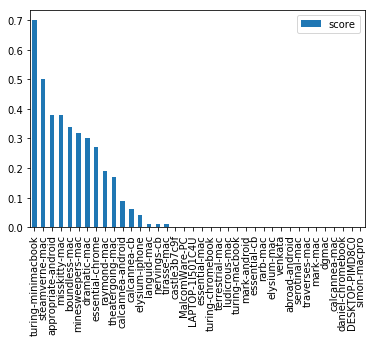

In [48]:
plt.figure(figsize=(20, 30))
score2.sort_values("score", ascending=False).plot.bar()
plt.show()